In [1]:
import pandas as pd
import os
from imports import *

class PascalVOC:
    """
    Handle Pascal VOC dataset
    """
    def __init__(self, root_dir):
        """
        Summary: 
            Init the class with root dir
        Args:
            root_dir (string): path to your voc dataset
        """
        self.root_dir = root_dir
        self.img_dir =  os.path.join(root_dir, 'JPEGImages/')
        self.ann_dir = os.path.join(root_dir, 'Annotations')
        self.set_dir = os.path.join(root_dir, 'ImageSets', 'Main')
        self.cache_dir = os.path.join(root_dir, 'csvs')
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

    def list_image_sets(self):
        """
        Summary: 
            List all the image sets from Pascal VOC. Don't bother computing
            this on the fly, just remember it. It's faster.
        """
        return [
            'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train',
            'tvmonitor']

    def _imgs_from_category(self, cat_name, dataset):
        """
        Summary: 
        Args:
            cat_name (string): Category name as a string (from list_image_sets())
            dataset (string): "train", "val", "train_val", or "test" (if available)
        Returns:
            pandas dataframe: pandas DataFrame of all filenames from that category
        """
        filename = os.path.join(self.set_dir, cat_name + "_" + dataset + ".txt")
        df = pd.read_csv(
            filename,
            delim_whitespace=True,
            header=None,
            names=['filename', 'true'])
        return df

    def imgs_from_category_as_list(self, cat_name, dataset):
        """
        Summary: 
            Get a list of filenames for images in a particular category
            as a list rather than a pandas dataframe.
        Args:
            cat_name (string): Category name as a string (from list_image_sets())
            dataset (string): "train", "val", "train_val", or "test" (if available)
        Returns:
            list of srings: all filenames from that category
        """
        df = self._imgs_from_category(cat_name, dataset)
        df = df[df['true'] == 1]
        return df['filename'].values

In [2]:
def get_data(pv):
    idx2label = pv.list_image_sets()
    label2idx = {o:i for i,o in enumerate(idx2label)}
    train_dict,val_dict = {}, {}
    
    for l in idx2label:
        val_dict[l] = pv.imgs_from_category_as_list(l, 'val')
        train_dict[l] = pv.imgs_from_category_as_list(l, 'train')
    
    train_images = list(set([oo for o in train_dict.values() for oo in o]))
    val_images = list(set([oo for o in val_dict.values() for oo in o]))
    
    train_labels = np.zeros((len(train_images), 20), dtype=np.float32)
    val_labels = np.zeros((len(val_images), 20), dtype=np.float32)
    
    imageName2idx = {o:i for i,o in enumerate(train_images)}
    for l in idx2label:
        contained_imgs = train_dict[l]
        labelindex = label2idx[l]
        for img_n in contained_imgs:
            train_labels[imageName2idx[img_n], labelindex] = 1

    imageName2idx = {o:i for i,o in enumerate(val_images)}    
    for l in idx2label:
        contained_imgs = val_dict[l]
        labelindex = label2idx[l]
        for img_n in contained_imgs:
            val_labels[imageName2idx[img_n], labelindex] = 1
            
    return train_labels, val_labels, train_images, val_images

In [3]:
class VOCDataset(Dataset):
    def __init__(self, labels , mainfolder, image_names, transform=None):
        self.labels = labels
        self.image_names = image_names
        self.mainfolder = Path(mainfolder)
        self.transform = transform
        
    def __getitem__(self, i):
        img = Image.open(self.mainfolder/ (self.image_names[i] + '.jpg') ).convert("RGB")
        img.load()
        if self.transform: img = self.transform(img)
        return img, self.labels[i]
    
    def __len__(self):
        return len(self.image_names)

In [4]:
class config:
    BATCH_SIZE = 64
    NUM_WORKS = 4
    NUM_EPOCHS = 3
    NUM_CLASSES = 20
    LR = 0.01
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    MOMENTUM = 0.9
    mainfolder = './VOCdevkit/VOC2012/JPEGImages/'
    savepath = './saved_model.pth'

In [6]:
from torch.utils.data import Sampler
class testSampler(Sampler):
    def __init__(self, ds_total):
        self.ds_total = ds_total

    def __iter__(self):
        return iter(range(self.ds_total))

    def __len__(self):
        return self.ds_total

In [7]:

# criterion = nn.BCELoss()
class ResNet18(nn.Module):
    def __init__(self, num_classes, pretrain, freeze):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrain)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.sigmoid = nn.Sigmoid()
        if freeze:
            for child in self.model.named_children():
                if child == 'fc': continue
                for param in child[1].parameters():
                    param.requires_grad = True

    def forward(self, inputs):
        x = inputs
        y = self.model(inputs)
        # y = self.sigmoid(y)
        return y

In [17]:
def train(model, dl_trn, optimizer, criterion, num_instances):
    model.train()
    trn_loss, trn_prec = 0, 0
    for X, y in dl_trn:
        inputs = X.to(config.device)
        labels = y.to(config.device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * X.size(0)
        trn_prec += precision_score(outputs, labels)[0]
    trn_loss /= num_instances
    trn_prec /= len(dl_trn)
    return trn_loss, trn_prec

def test(model, dl_val, criterion, num_instances):
    model.eval()
    val_loss = 0 
    outputs_list, labels_list = [], []
    with torch.no_grad():
        for X, y in dl_val:
            inputs = X.to(config.device)
            labels = y.to(config.device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * X.size(0)
            outputs_list.append(outputs)
            labels_list.append(labels)
    val_loss /= num_instances
    outputs = torch.cat(outputs_list)
    labels = torch.cat(labels_list)
    val_prec = precision_score(outputs, labels)[0]
    return val_loss, val_prec, outputs, labels

def fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion):
    optimizer = torch.optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM)
    best_prec = 0
    trn_losses, val_losses, val_precs = [], [], []
    for epoch in range(config.NUM_EPOCHS):
        # train
        trn_loss, trn_prec = train(model, dl_trn, optimizer, criterion, len(ds_trn))
        # val
        val_loss, val_prec, outputs, labels = test(model, dl_val, criterion, len(ds_val))
        trn_losses.append(trn_loss)
        val_losses.append(val_loss)
        val_precs.append(val_prec)
        if val_prec > best_prec:
            best_prec = val_prec
            best_weights = model.state_dict()
            torch.save(best_weights, config.savepath)
            best_epoch = epoch
        print(f'Epoch {epoch}/{config.NUM_EPOCHS - 1}, trn_loss {trn_loss} val_loss {val_loss} val_prec {val_prec}')
    return best_weights, best_epoch, [best_prec, trn_losses, val_losses, val_precs]

In [18]:
def main():
    pv=PascalVOC('./VOCdevkit/VOC2012/')
    train_labels, val_labels, train_images, val_images = get_data(pv)
    transform = transforms.Compose([transforms.Resize(224),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    ds_trn = VOCDataset(train_labels, config.mainfolder, image_names=train_images, transform=transform)
    ds_val = VOCDataset(val_labels, config.mainfolder, image_names=val_images, transform=transform)
    test_sampler = testSampler(len(ds_val))
    dl_trn = DataLoader(ds_trn, batch_size=config.BATCH_SIZE)
    dl_val = DataLoader(ds_val, batch_size=config.BATCH_SIZE, sampler=test_sampler)

    criterion = nn.BCEWithLogitsLoss()
    model = ResNet18(config.NUM_CLASSES, pretrain=True, freeze=False)
    # best_weights = torch.load('saved_model.pth')
    # model.load_state_dict(best_weights)
    model = model.to(config.device)
    best_weights, best_epoch, first_model = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)
    val_loss, val_prec, outputs, labels = test(model, dl_val, criterion, len(ds_val))
    
    return val_loss, val_prec, outputs, labels

In [19]:
def get_tail(pred, ci, topk=50):
    """most probable topk>0"""
    pred_ci = pred[:, ci]
    if topk > 0:
        pred = np.argsort(pred_ci.detach().cpu().numpy())[-topk:]
    else:
        pred = np.argsort(pred_ci.detach().cpu().numpy())[:topk]
    return pred

def show_image(index, ds_val, name):
    w=20
    h=20
    fig=plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(ds_val[index[i-1]][0].permute(1,2,0).numpy())
    plt.savefig('image/' + name)
    
def c(x): return x.cpu().numpy()

def tailacc(pred_c, label_c, threshold):
    """
    pred_c: (batch_size, )
    label_c: (batch_size)
    """
    denom = ((pred_c>threshold).sum() + 1e-7)
    c1 = pred_c > threshold
    c2 = label_c > threshold
    fac = (c1 * c2).sum()
    return  fac / denom 

def precision_score(pred, label, threshold=0.651):
    total_prec = 0
    pred = torch.sigmoid(pred) > threshold
    num_c = label.shape[1]
    pred = c(pred)
    label = c(label)
    all_precs = []
    for i in range(num_c):
        pred_c = pred[:, i]
        label_c = label[:, i]
        prec = (pred_c == label_c)[np.where(pred_c == 1)].sum() / (pred_c.sum() + 1e-7)
        all_precs.append(prec)
#     print(total_prec/num_c)
    return np.mean(all_precs), all_precs

def accuracy_score(pred, label, threshold=0.5):
    total_prec = 0
    pred = torch.sigmoid(pred) > threshold
    num_c = label.shape[1]
    pred = c(pred)
    label = c(label)
    all_precs = []
    for i in range(num_c):
        pred_c = pred[:, i]
        label_c = label[:, i]
        prec = (pred_c == label_c).sum() / len(pred_c)
        all_precs.append(prec)
#     print(total_prec/num_c)
    return np.mean(all_precs), all_precs

In [ ]:
if __name__ == "__main__":
    val_loss, val_prec, outputs, labels = main()

Epoch 0/2, trn_loss 0.22743130423804983 val_loss 0.1421661669295329 val_prec 0.6640575680576066
Epoch 1/2, trn_loss 0.1260972176231307 val_loss 0.11207894969775713 val_prec 0.8726224262692494


## Visualize image

In [100]:
cis = np.random.choice(list(range(20)), 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

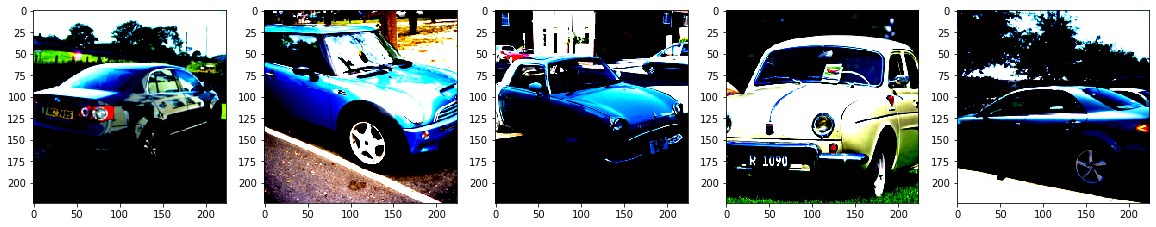

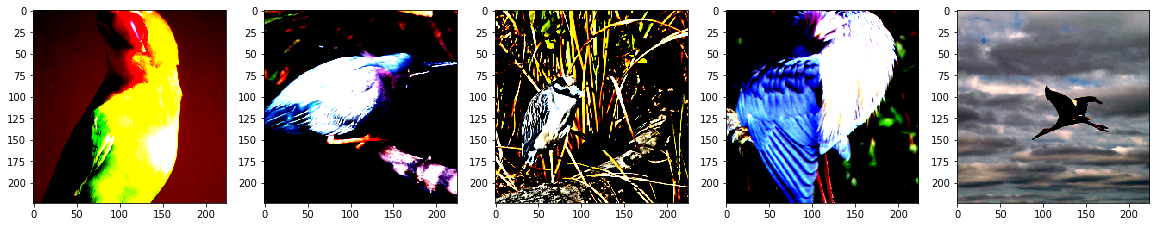

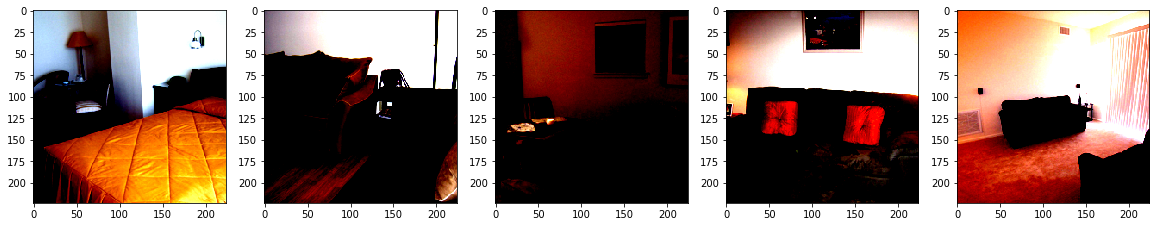

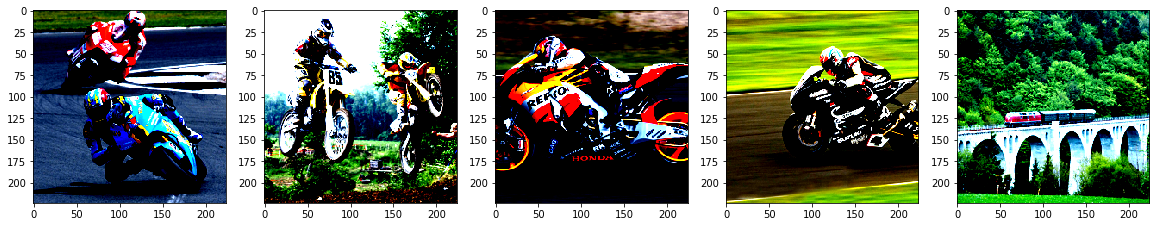

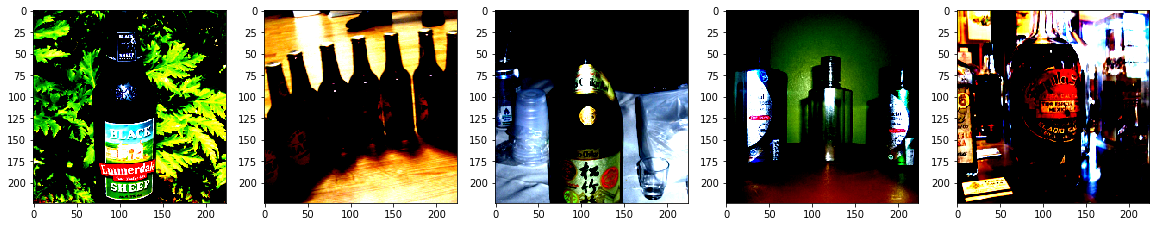

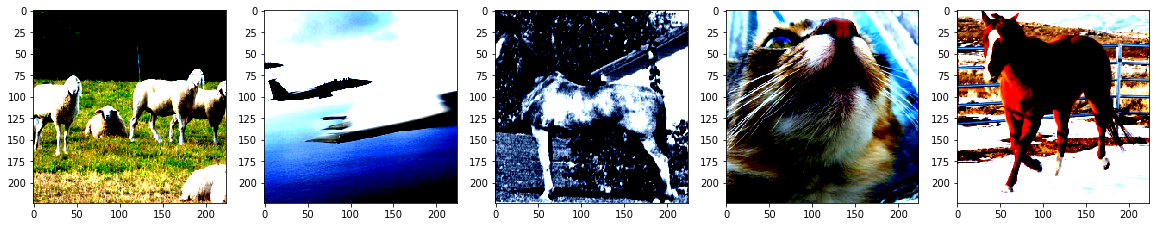

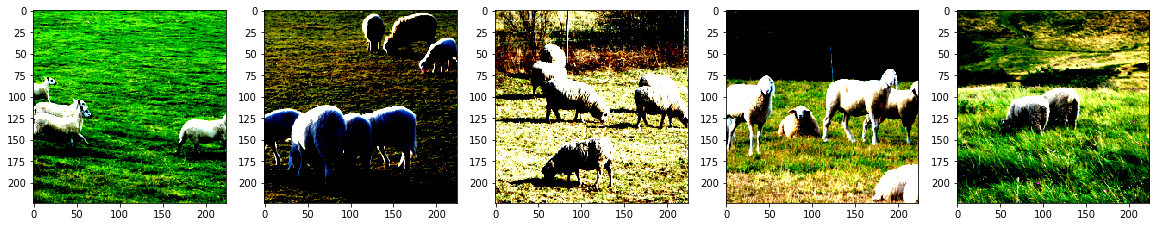

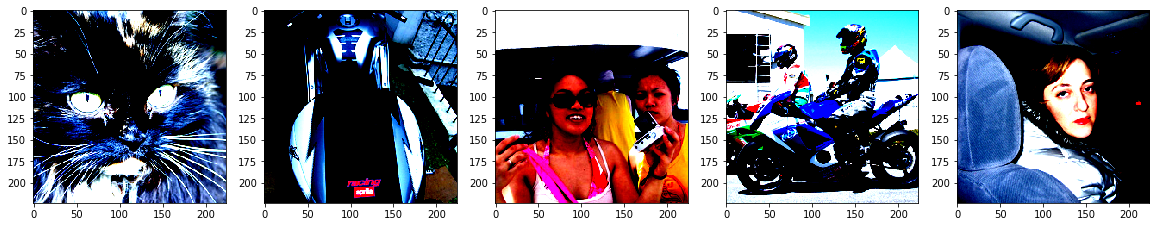

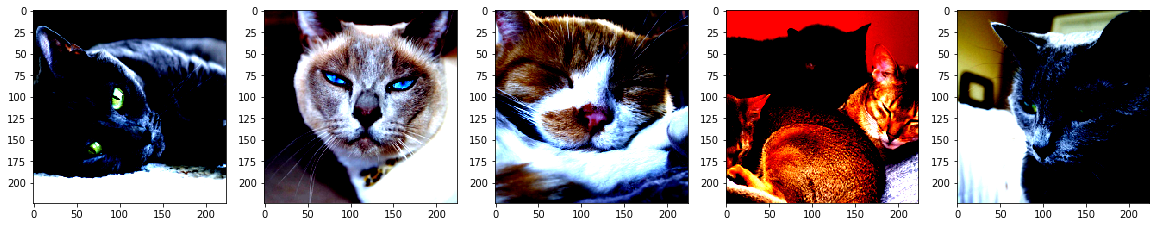

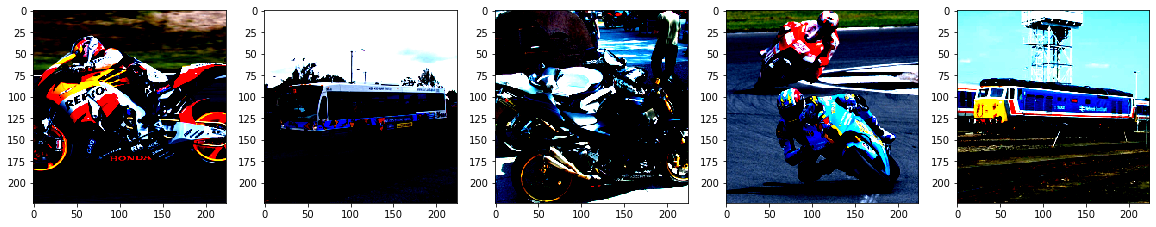

In [124]:
import warnings
warnings.filterwarnings("ignore")
for ci in cis:
    topk = 5
    most_probable = get_tail(outputs, ci, topk)
    most_unprobable = get_tail(outputs, ci, -topk)
    show_image(most_probable, ds_val, f'top_5_{idx2label[ci]}.png')
    show_image(most_unprobable, ds_val, f'low_5_{idx2label[ci]}.png')

In [46]:
c_max = np.min(np.max(torch.sigmoid(outputs.cpu()).numpy(),  axis=0))

In [135]:
tail_precs=[]
t_range = np.linspace(0, c_max, 20)
for t in t_range:
    tail_prec = np.mean([tailacc(c(torch.sigmoid(outputs[:,i])), c(labels[:,i]), t) for i in range(20)])
    tail_precs.append(tail_prec)

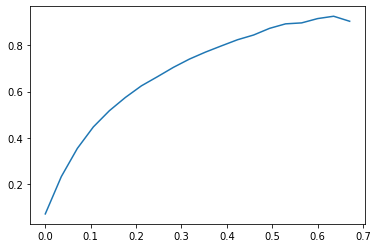

In [137]:
plt.plot(t_range, tail_precs)
plt.savefig('Average precision change.png')

In [162]:
t_range = np.linspace(0, 0.9, 30)
precs = []
for t in t_range:
    precs.append(precision_score(outputs, labels, t))
highest_prec = max(precs)

In [163]:
for l, p in zip(idx2label, highest_prec[1]):
    print(l + f':\t{np.round(p,4)}')
print(f"mean prec: {np.round(highest_prec[0], 4)}")

aeroplane:	0.9912
bicycle:	0.9727
bird:	0.988
boat:	0.9588
bottle:	1.0
bus:	0.9908
car:	0.9355
cat:	0.9799
chair:	0.7984
cow:	0.8
diningtable:	0.8125
dog:	0.9631
horse:	0.8429
motorbike:	0.9784
person:	0.97
pottedplant:	0.6667
sheep:	0.9697
sofa:	0.9091
train:	1.0
tvmonitor:	0.9746
mean prec: 0.9251


In [169]:
t_range[np.argmax([o[0] for o in precs])]

0.6517241379310345

In [179]:
t_range = np.linspace(0, 0.9, 30)
accs = []
for t in t_range:
    accs.append(accuracy_score(outputs, labels, t))
highest_acc = max(accs)

In [180]:
highest_acc[0]

0.9661257083977333